In [1]:
import torch
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset, TensorDataset
from torch.utils.data.dataloader import DataLoader
import json
import pickle
import string
from DiacriticDataset import DiacriticDataset
from DiacriticDataset import DiacriticDatasetShaddah
import pyarabic.araby as araby
import pyarabic.number as number
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
train_dataset = DiacriticDatasetShaddah('Dataset_with_shaddah/train_cleaned_withshadda_215.txt','Dataset_with_shaddah/letter_to_id.pickle','Dataset_with_shaddah/id_to_letter.pickle','Dataset_with_shaddah/diacritic_to_id.pickle','Dataset_with_shaddah/id_to_diacritic.pickle','Dataset_with_shaddah/word_to_id.pickle','Dataset_with_shaddah/id_to_word.pickle','Dataset/diacritic_to_id.pickle','Dataset/id_to_diacritic.pickle')
test_dataset = DiacriticDatasetShaddah('Dataset_with_shaddah/test_cleaned_withshadda_215.txt','Dataset_with_shaddah/letter_to_id.pickle','Dataset_with_shaddah/id_to_letter.pickle','Dataset_with_shaddah/diacritic_to_id.pickle','Dataset_with_shaddah/id_to_diacritic.pickle','Dataset_with_shaddah/word_to_id.pickle','Dataset_with_shaddah/id_to_word.pickle','Dataset/diacritic_to_id.pickle','Dataset/id_to_diacritic.pickle')
val_dataset = DiacriticDatasetShaddah('Dataset_with_shaddah/val_cleaned_withshadda_215.txt','Dataset_with_shaddah/letter_to_id.pickle','Dataset_with_shaddah/id_to_letter.pickle','Dataset_with_shaddah/diacritic_to_id.pickle','Dataset_with_shaddah/id_to_diacritic.pickle','Dataset_with_shaddah/word_to_id.pickle','Dataset_with_shaddah/id_to_word.pickle','Dataset/diacritic_to_id.pickle','Dataset/id_to_diacritic.pickle')

In [3]:
train_dataloader = DataLoader(train_dataset)
test_dataloader = DataLoader(test_dataset)
val_dataloader = DataLoader(val_dataset)

In [4]:
class AdvancedDiacriticNet(nn.Module):
    def __init__(self,word_emb_dim, hidden_dim, letter_vocab_size,diacritic_vocab_size,word_vocab_size):
        super(AdvancedDiacriticNet, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.letter_embedding = nn.Embedding(letter_vocab_size, word_emb_dim)
        self.lstm = nn.LSTM(input_size=word_emb_dim,hidden_size=hidden_dim,num_layers=2,bidirectional=True,batch_first=True)
        self.linear1 = nn.Linear(in_features=2*hidden_dim,out_features=2*hidden_dim)
        self.linear2 = nn.Linear(in_features=2*hidden_dim,out_features=2*hidden_dim)
        self.output = nn.Linear(in_features=2*hidden_dim,out_features=diacritic_vocab_size)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax()
        
        self.linear3 = nn.Linear(in_features=2*hidden_dim,out_features=2)
        
    def forward(self,letters,words):
        model_input = letters.to(self.device)
        embedded = self.letter_embedding(model_input)
        lstm_out, _ = self.lstm(embedded)
        lstm_view = lstm_out.view(letters.size()[1],-1)
        linear1_out = self.relu(self.linear1(lstm_view))
        linear2_out = self.relu(self.linear2(linear1_out))
        output_diacritic = self.softmax(self.output(linear2_out))
        
        linear3_out = self.relu(self.linear3(lstm_view))
        output_shaddah = self.softmax(linear3_out)
        
        return output_diacritic,output_shaddah
        

In [5]:
EPOCHS = 5
LETTER_EMBEDDING_DIM = 5
HIDDEN_DIM = 256

letter_vocab_size = len(train_dataset.letter_to_id)
diacritic_vocab_size = len(train_dataset.diacritic_to_id_nosh)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

model = AdvancedDiacriticNet(LETTER_EMBEDDING_DIM,HIDDEN_DIM,letter_vocab_size,diacritic_vocab_size,None)
model.load_state_dict(torch.load('Models/AdvancedNN_Shaddah'))

if use_cuda:
    model.cuda()
    
criterion_diacritics = nn.NLLLoss()
criterion_shaddahs = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
acumulate_grad_steps = 64

In [43]:
def eval_test():
    predictions = []
    true_labels = []
    true_predictions = 0
    total = 0
    id_to_diacritic_nosh = test_dataset.id_to_diacritic_nosh
    diacritic_to_id_sh = test_dataset.diacritic_to_id
    for batch_idx, input_data in enumerate(test_dataloader):
        letters = input_data[0]
        labels_diacritics_sh = input_data[1][0]
        labels_diacritics_nosh = input_data[2][0].to(model.device)
        labels_shaddahs = input_data[3][0].to(model.device)
        probs_diacritics,probs_shaddahs = model(letters,None)
        _, predicted_diacritics = torch.max(probs_diacritics.data, 1)
        _, predicted_shaddahs = torch.max(probs_shaddahs.data, 1) 
        for index,prediction in enumerate(predicted_diacritics.tolist()):
            if predicted_shaddahs[index]==1:
                if (id_to_diacritic_nosh[prediction]=='ـ') or (id_to_diacritic_nosh[prediction]=='ْ'):
                    adjusted_prediction = diacritic_to_id_sh['ّ']
                    predictions.append(adjusted_prediction)
#                 elif (id_to_diacritic_nosh[prediction]=='ْ'):
#                     adjusted_prediction = diacritic_to_id_sh['ْ']
#                     predictions.append(adjusted_prediction)
                else:
                    adjusted_prediction = diacritic_to_id_sh['ّ'+id_to_diacritic_nosh[prediction]]
                    predictions.append(adjusted_prediction)
            else:
                adjusted_prediction = diacritic_to_id_sh[id_to_diacritic_nosh[prediction]]
                predictions.append(adjusted_prediction)
                
        true_labels += labels_diacritics_sh.tolist()
        
    accuracy =(((torch.tensor(predictions)==torch.tensor(true_labels)).sum()).item())/len(predictions) 
    return accuracy,predictions,true_labels


In [9]:
def eval_validation():
    predictions = []
    true_labels = []
    true_prediction_diacritics = 0
    true_prediction_shaddahs = 0
    total = 0
    for batch_idx, input_data in enumerate(val_dataloader):

        letters = input_data[0]
        labels_diacritics = input_data[2][0].to(model.device)
        labels_shaddahs = input_data[3][0].to(model.device)
        probs_diacritics,probs_shaddahs = model(letters,None)
        _, predicted_diacritics = torch.max(probs_diacritics.data, 1)
        _, predicted_shaddahs = torch.max(probs_shaddahs.data, 1)
        true_prediction_diacritics += ((predicted_diacritics==labels_diacritics).sum()).item()
        true_prediction_shaddahs += ((predicted_shaddahs==labels_shaddahs).sum()).item()
        total += letters.size()[1]
        
        predictions += predicted_diacritics.tolist()
        true_labels += labels_diacritics.tolist()
        
    Accuracy_diacritics = true_prediction_diacritics/total
    Accuracy_shaddahs = true_prediction_shaddahs/total
    return Accuracy_diacritics,Accuracy_shaddahs,predictions,true_labels



In [ ]:
def test_word_accuracy():
    true_prediction = 0
    total = 0
    wrong_words = []
    for batch_idx, input_data in enumerate(test_dataloader):

        letters = input_data[0]
        diacritics = input_data[1]
        labels = diacritics[0].to(model.device)
        probs = model(letters,None)
        _, predicted = torch.max(probs.data, 1)
        sentence = ''

        for index,letter_id in enumerate(letters[0]):
            letter = train_dataset.id_to_letter[letter_id.item()]
            diacritic = train_dataset.id_to_diacritic[predicted[index].item()]
            if letter_id==2:
                sentence += " "
                diacritic = ""
            elif predicted[index] == 3: 
                diacritic = ""

            sentence += (letter+diacritic)


        true_words = input_data[2][0]
        predicted_words = sentence.split()

        for index,predicted_word in enumerate(predicted_words):
            predicted_word_id = train_dataset.word_to_id.get(predicted_word,'NOT_FOUND')
            if predicted_word_id != 'NOT_FOUND':
                if predicted_word_id == true_words[index]:
                    true_prediction += 1
                else:
                    wrong_words.append(train_dataset.id_to_word[true_words[index].item()])
            else:
                wrong_words.append(train_dataset.id_to_word[true_words[index].item()])
                continue


        total += len(predicted_words)



    word_accuracy = true_prediction/total
    return word_accuracy

In [12]:
loss_list_train = []
for epoch in range(1):
    loss_train_total = 0
    i = 0
    for batch_idx, input_data in enumerate(train_dataloader):           
        i += 1
        letters = input_data[0]
        labels_diacritics = input_data[2][0].to(model.device)
        labels_shaddahs = input_data[3][0].to(model.device)
        probs_diacritics,probs_shaddahs = model(letters,None)
        loss_diacritics = criterion_diacritics(probs_diacritics,labels_diacritics)
        loss_shaddahs = criterion_shaddahs(probs_shaddahs,labels_shaddahs)
        loss = loss_diacritics + loss_shaddahs
        loss = loss/ acumulate_grad_steps
        loss.backward()
        
        if i % acumulate_grad_steps == 0:
            optimizer.step()
            model.zero_grad()
        
        loss_train_total += loss.item()
            
    
    loss_train_total = loss_train_total / len(train_dataset)
    loss_list_train.append(float(loss_train_total))
    e_interval = i
    val_accuracy_diacritics,val_accuracy_shaddahs,_,_ = eval_validation()
    print("Epoch {} Completed,\tTrain Loss: {}\tValidation Diacritic Accuracy: {:.3f}\tValidation Shaddah Accuracy: {:.3f}".format(epoch + 1, np.mean(loss_list_train[-e_interval:]),val_accuracy_diacritics,val_accuracy_shaddahs))

/anaconda/envs/project/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/anaconda/envs/project/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1 Completed,	Train Loss: 0.001806983113910143	Validation Diacritic Accuracy: 0.957	Validation Shaddah Accuracy: 0.995


In [14]:
torch.save(model.state_dict(), 'Models/AdvancedNN_Shaddah')

In [44]:
diacritic_accuracy,predictions,true = eval_test()
word_accuracy = 0
print("Test Diacritic Accuracy: {:.3f}\tTest Word Accuracy: {:3f}".format(diacritic_accuracy,word_accuracy))

/anaconda/envs/project/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/anaconda/envs/project/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test Diacritic Accuracy: 0.952	Test Word Accuracy: 0.000000


In [ ]:
true_shaddah = 0
total_wordswithshadda = 0
true_noshaddah = 0
total_wordswithnoshadda = 0
for batch_idx, input_data in enumerate(test_dataloader):
        
    letters = input_data[0]
    diacritics = input_data[1]
    labels = diacritics[0].to(model.device)
    probs = model(letters,None)
    _, predicted = torch.max(probs.data, 1)
    sentence = ''

    for index,letter_id in enumerate(letters[0]):
        letter = train_dataset.id_to_letter[letter_id.item()]
        diacritic = train_dataset.id_to_diacritic[predicted[index].item()]
        if letter_id==2:
            sentence += " "
            diacritic = ""
        elif predicted[index] == 3: 
            diacritic = ""

        sentence += (letter+diacritic)
    
        
    true_words = input_data[2][0]
    predicted_words = sentence.split()

    for index,predicted_word in enumerate(predicted_words):
        predicted_word_id = train_dataset.word_to_id.get(predicted_word,'NOT_FOUND')
        true_word = train_dataset.id_to_word[true_words[index].item()]
        if araby.strip_shadda(true_word) != true_word: 
            if predicted_word_id != 'NOT_FOUND':
                if predicted_word_id == true_words[index]:
                    true_shaddah+= 1
                    
            total_wordswithshadda += 1
            
        else:
            if predicted_word_id != 'NOT_FOUND':
                if predicted_word_id == true_words[index]:
                    true_noshaddah+= 1           
            total_wordswithnoshadda += 1
    
    
percentage_shadda = true_shaddah/total_wordswithshadda
percentage_noshadda = true_noshaddah/total_wordswithnoshadda
print("Percentage of correctly classified words with shaddah: ",percentage_shadda)
print("Percentage of correctly classified words without shaddah: ",percentage_noshadda)


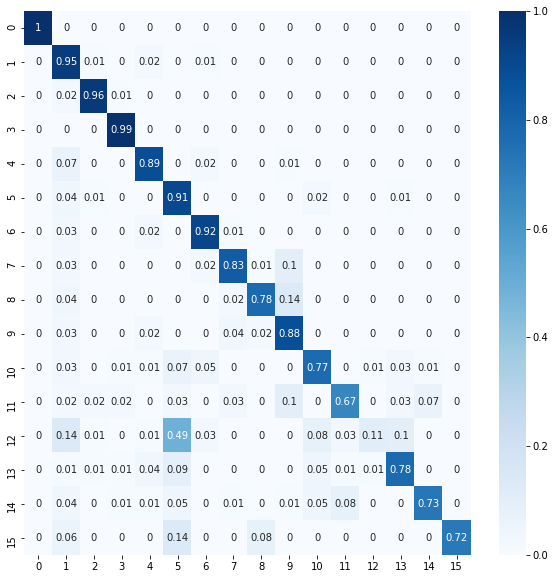

In [45]:
plt.figure(figsize=(10, 10))

cm  = confusion_matrix(true,predictions,normalize='true').round(2)

f = sns.heatmap(cm, annot=True,cmap='Blues')

In [46]:
for i in np.diag(cm):
    print(i)


1.0
0.95
0.96
0.99
0.89
0.91
0.92
0.83
0.78
0.88
0.77
0.67
0.11
0.78
0.73
0.72
